# CS 410: Text Information Systems

## Final Project - Final Report <br/> Project Type: Classification Competition <br/>Team: The Classifiers <br/> November 27, 2020

### Praveen Pathri (ppathri2@illinois.edu) <br/>  Steven Piquito (piquito2@illinois.edu) <br/>  Mattias Rumpf (mrumpf2@illinois.eu)

### References and web-sites used in this code extensively:
    
https://towardsdatascience.com/sarcasm-detection-step-towards-sentiment-analysis-84cb013bb6db <br/>
https://simpletransformers.ai/docs/usage/

### Key Libraries Used in this Project to Date:

As part of our project certain libraries are being used extensively. 

For the core traditional ML models as well as feature vector transformations:

#### SKLearn Library<br/>

For the implementation of the RoBERTa pre-trained neural network architecture, the following libaries are used:

#### HuggingFace Transformer Library<br/>
#### SimpleTransformer.ai Library



### Description of Work In This Notebook:

This code notebook explains the next steps we followed post the completion of the project progress report notebook and should be seen (or read) as a follow on to that piece of work. Our total project documentation is covered by both notebooks as well additional descriptions of further testing we performed/optimisation as part of the project.

This notebook focuses on the final implementation of the chosen RoBERTa  transformer model implementation designated by the project team for investigation and use in the classification competition and leaderboard. Optimisation and experimentation is described in another document, however this code focuses on the following:

1. The creation and learning of an existing RoBERTa model widely used and available in the simpletransformers.ai library
2. Some feature engineering in the form of stemming, stop word removal and general cleaning of text input data
3. The inclusion of Context in the model to enhance the model performance

Additional commentary and description can be found in the document below code snippets as to what the project team found to be working or not working.


### Import key python libraries for this project

The below cell installs all necessary key libraries used in this notebook first should they not already be installed:

In [1]:
!pip install jsonlines
!pip install pandas
!pip install transformers
!pip install nltk
!pip install torch

The below cell imports all necessary libraries used in this notebook :

In [2]:
import os
import jsonlines
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import simpletransformers
import torch

#libraries for RoBERTa
from simpletransformers.classification import ClassificationModel,ClassificationArgs
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


In Transformers v4.0.0, the default path to cache downloaded models changed from '~/.cache/torch/transformers' to '~/.cache/huggingface/transformers'. Since you don't seem to have overridden and '~/.cache/torch/transformers' is a directory that exists, we're moving it to '~/.cache/huggingface/transformers' to avoid redownloading models you have already in the cache. You should only see this message once.


### Importing of training and test data

The following code reads both the train and test JSON files and imports the data into a python dictionary format:

In [3]:
test_file = 'data/test.jsonl'
train_file = 'data/train.jsonl'

data_train = []
iter = 1
with jsonlines.open(train_file) as f:
    for line in f.iter():        
        iter +=1
        data_train.append(line)

data_test = []
iter = 1
with jsonlines.open(test_file) as f:
    for line in f.iter():
        iter +=1
        data_test.append(line)

print("Count of training data entries:")
print(len(data_train))
print("Count of test data entries:")
print(len(data_test))

Count of training data entries:
5000
Count of test data entries:
1800


The following code converts the training and test data dictionaries into a Pandas DataFrame format for use later in the RoBERTa model

In [4]:
train_data_pd = pd.DataFrame.from_dict(data_train)
test_data_pd = pd.DataFrame.from_dict(data_test)
print("Training and Test Datasets converted to Pandas DataFrames...")

Training and Test Datasets converted to Pandas DataFrames...


### Adding Context to training and test datasets as well as basic NLP processing

This code will append the context data to the response/text data linearly so as to add context information to the various model input feature vectors and capture the additional information therein. 

Additionally, some basic processing such is performed on the raw data such as stemming, removal of stop words

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, SpaceTokenizer
from nltk.stem import PorterStemmer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\whiteboardRoom\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\whiteboardRoom\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


The next code snippet performs the addition of context information which you should note <b>ONLY</b> includes the addition of the preceding CONTEXT sentence to the response and not the sentence before that as well (i.e. the model uses only one of the two additional CONTEXT sentences):

In [6]:

all_stopwords = stopwords.words('english')
tk = SpaceTokenizer() 
ps = PorterStemmer()

for i in range(len(train_data_pd)):
    train_data_pd['response'][i]=train_data_pd['response'][i]+train_data_pd['context'][i][1]
    train_data_pd['response'][i]=train_data_pd['response'][i].replace('@USER', '').strip().lower()    
    text_tokens = tk.tokenize(train_data_pd['response'][i])
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
    test4=""
    for i in tokens_without_sw:
        test4 = test4 + " "+ps.stem(i)
    test4.strip()
    train_data_pd['response'][i]=test4     


for i in range(len(test_data_pd)):
    test_data_pd['response'][i]=test_data_pd['response'][i]+test_data_pd['context'][i][1]
    test_data_pd['response'][i]=test_data_pd['response'][i].replace('@USER', '').strip().lower()

    text_tokens = tk.tokenize(test_data_pd['response'][i])
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
    test4=""
    for i in tokens_without_sw:
        test4 = test4 + " "+ps.stem(i)
    test4.strip()
    test_data_pd['response'][i]=test4
 
    

print("Converted response PD data to include Context Data")
print("Converted response to lowercase and removed stop words as well as @USER")
print("Converted response to stem words using PortStemmer")


Converted response PD data to include Context Data
Converted response to lowercase and removed stop words as well as @USER
Converted response to stem words using PortStemmer


Perform a random test print of the constructed response+context after NLP pre-processing to see if all is ok:

In [7]:
print(test_data_pd['response'][10])

define this way : 1 . desiring the good of the other ; wanting them to thrive / flourish , which means they'd get free from the attitudes you mention ; 2 . doing whatever's in your control / power to advance their good ; at least * not * wishing them ill , * not * hating them .  ok , you ’ re right , but how do you love someone who hates you , and wants you to not exist ? how do you love someone doesn ’ t share basic morals ?


Here we turn the labelled training data text format 'SARCASM' or 'NOT SARCASM' into a binary 1/0 list to for easier input into the models:

In [8]:
#Define the vector of actual results:
Actual_Results = []    
for  l in data_train:
    if l['label'] == 'SARCASM':
        Actual_Results.append(1)
    else:
        Actual_Results.append(0)

### Splitting of the project training dataset randomly

The code below splits the training dataset into a random  (new) training and test dataset (i.e. only using the course project training data to train and test locally so far):

#### NOTE THAT RANDOM_STATE is set to zero to provide a fixed seed to the random generator for consistent results


In [9]:
#getting training dataset features and labels
features = train_data_pd['response']
labels = train_data_pd['label']
labels = Actual_Results



# Splitting of training data into train and test data
rawdata_train, rawdata_test, rawlabels_train, rawlabels_test = train_test_split(features, labels, test_size = .05, random_state = 0)

print("Training dataset split into this many train samples:")
print(len(rawdata_train))
print("Training dataset split into this many test/validation samples:")
print(len(rawdata_test))



Training dataset split into this many train samples:
4750
Training dataset split into this many test/validation samples:
250


### Final Model : RoBERTa

The below code implements the SimpleTransformers.ai implementation of RoBERTa and calculates a number of metrics including:
    
1. Accuracy on both train and test sets
2. The precision, recall and F1 score on the training data
3. The precision, recall and F1 score on the test data

In [10]:
#Import the simpletransformers model library
from simpletransformers.classification import ClassificationModel,ClassificationArgs

In [11]:
#Create a training dataset in a Panda DataFrame format ready for the model
train_df = pd.DataFrame({
    'text': rawdata_train.str.replace('@USER', '', regex=False).str.strip(),
    'labels': rawlabels_train
})

In [12]:
#Create a test dataset in a Panda DataFrame format ready for the model
test_df = pd.DataFrame({
    'text': rawdata_test.str.replace('@USER', '', regex=False).str.strip(),
    'labels': rawlabels_test
})

#### Set up RoBERTa transformer model

The below code establishes and imports the RoBERTa transformer model. There are two possible options here, one including cuda support (if you have this available) and one excluding cuda support. The difference is primarily the speed of model training/estimation. the code has been set up to use or not use Cuda depending on the machine where the code is being executed (this is done through the torch.cuda.is_available() function which returns true if cuda is an option).


In [13]:
# Create a ClassificationModel
# for training from scratch
import torch

cuda_available = torch.cuda.is_available()
print("Does system have CUDA support?")
print(cuda_available)

model = ClassificationModel('roberta', 'roberta-base', use_cuda=cuda_available) # You can set class weights by using the optional weight argument


# for loading my pre-trained model
#model = ClassificationModel('roberta', 'outputs/checkpoint-594-epoch-1', use_cuda=False)

Does system have CUDA support?
False


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Perform model training (this may take some time if non CUDA support):

In [14]:
model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "num_train_epochs": 1,
    "model_args.lazy_loading" : True
}

# Train the model
model.train_model(train_df,args=model_args)

c:\users\whiteboardroom\.conda\envs\python_3_7_test\lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(594, 0.613937029608773)

Evaluate the model performance on the training dataset:

In [15]:
# Evaluate the model - training 
result_train, model_outputs_train, wrong_predictions_train = model.eval_model(train_df, 
                                                            f1=f1_score,
                                                            acc=accuracy_score,
                                                            prec= precision_score,
                                                            rec= recall_score)


Through printing of the below output of result_train, we can see relevant accuracy, precisionm, recall and F1 scores for the model based on predictions on the training dataset. A resulting f1 score of 0.84 is observed indicating a high degree of accuracy on the training dataset for the model priediction.

In [16]:
#Print training result metrics
result_train

{'mcc': 0.5444795211391988,
 'tp': 1822,
 'tn': 1846,
 'fp': 525,
 'fn': 557,
 'f1': 0.7710537452391028,
 'acc': 0.7722105263157895,
 'prec': 0.7763101832126118,
 'rec': 0.7658680117696511,
 'eval_loss': 0.49800905630444037}

Next we need to evaluate the model performance on the test dataset (the test set randomly sampled from the trainign data...not the course test set for the leaderboard):

In [17]:
# Evaluate the model - testing
result_test, model_outputs_test, wrong_predictions_test = model.eval_model(test_df, 
                                                            f1=f1_score,
                                                            acc=accuracy_score,
                                                            prec= precision_score,
                                                            rec= recall_score)


From printing the below result_test metrics, we can see that the model appears to perform relatively well with an F1 score 0f 0.81...slightly lower than training set but still relatively good. This is a good result and indicative of a model that hopefully was not overfit to the training data

In [18]:
#Print out the model performance metrics on the test set
result_test

{'mcc': 0.5353549404443486,
 'tp': 91,
 'tn': 101,
 'fp': 28,
 'fn': 30,
 'f1': 0.7583333333333334,
 'acc': 0.768,
 'prec': 0.7647058823529411,
 'rec': 0.7520661157024794,
 'eval_loss': 0.49071075581014156}

### Performing predictions on project test data for LiveDataLab

Perform predictions on the project test data for the competition for upload to LiveDataLab for grading

#### Perform RoBERTa predictions for project test set

In [19]:
# getting training dataset features and labels
features_test = test_data_pd['response']
id_final_test = test_data_pd['id']

predictions_test, raw_outputs_test = model.predict(features_test)


Write the predictions from the RoBERTa model to an output text file called 'answers.txt' for storage and uploading the the course competition leaderboard:

In [22]:
#Writing the RoBERTa Classifier predictions to the output file: RoBERTa_answers.txt
y_pred = predictions_test
f = open("answers.txt", "w")
#f = open("RoBERTa_answers.txt", "w")
for i in range(len(id_final_test)):
    i_result = y_pred[i]
    pred_id = id_final_test[i]
    if i_result == 1:
        f.write(pred_id + ',' + "SARCASM" +"\n")
    else:
        f.write(pred_id + ',' + "NOT_SARCASM" +"\n")
f.close()



By taking the resulting output file generated above and submission to the project LiveDataLab scoreboard, a resulting model score of F1 = 0.737 was achieved (beating the baseline score of 0.723). 

A sample screenshot of the model is included below and can be seen under the username PIQUITO2 at rank 28

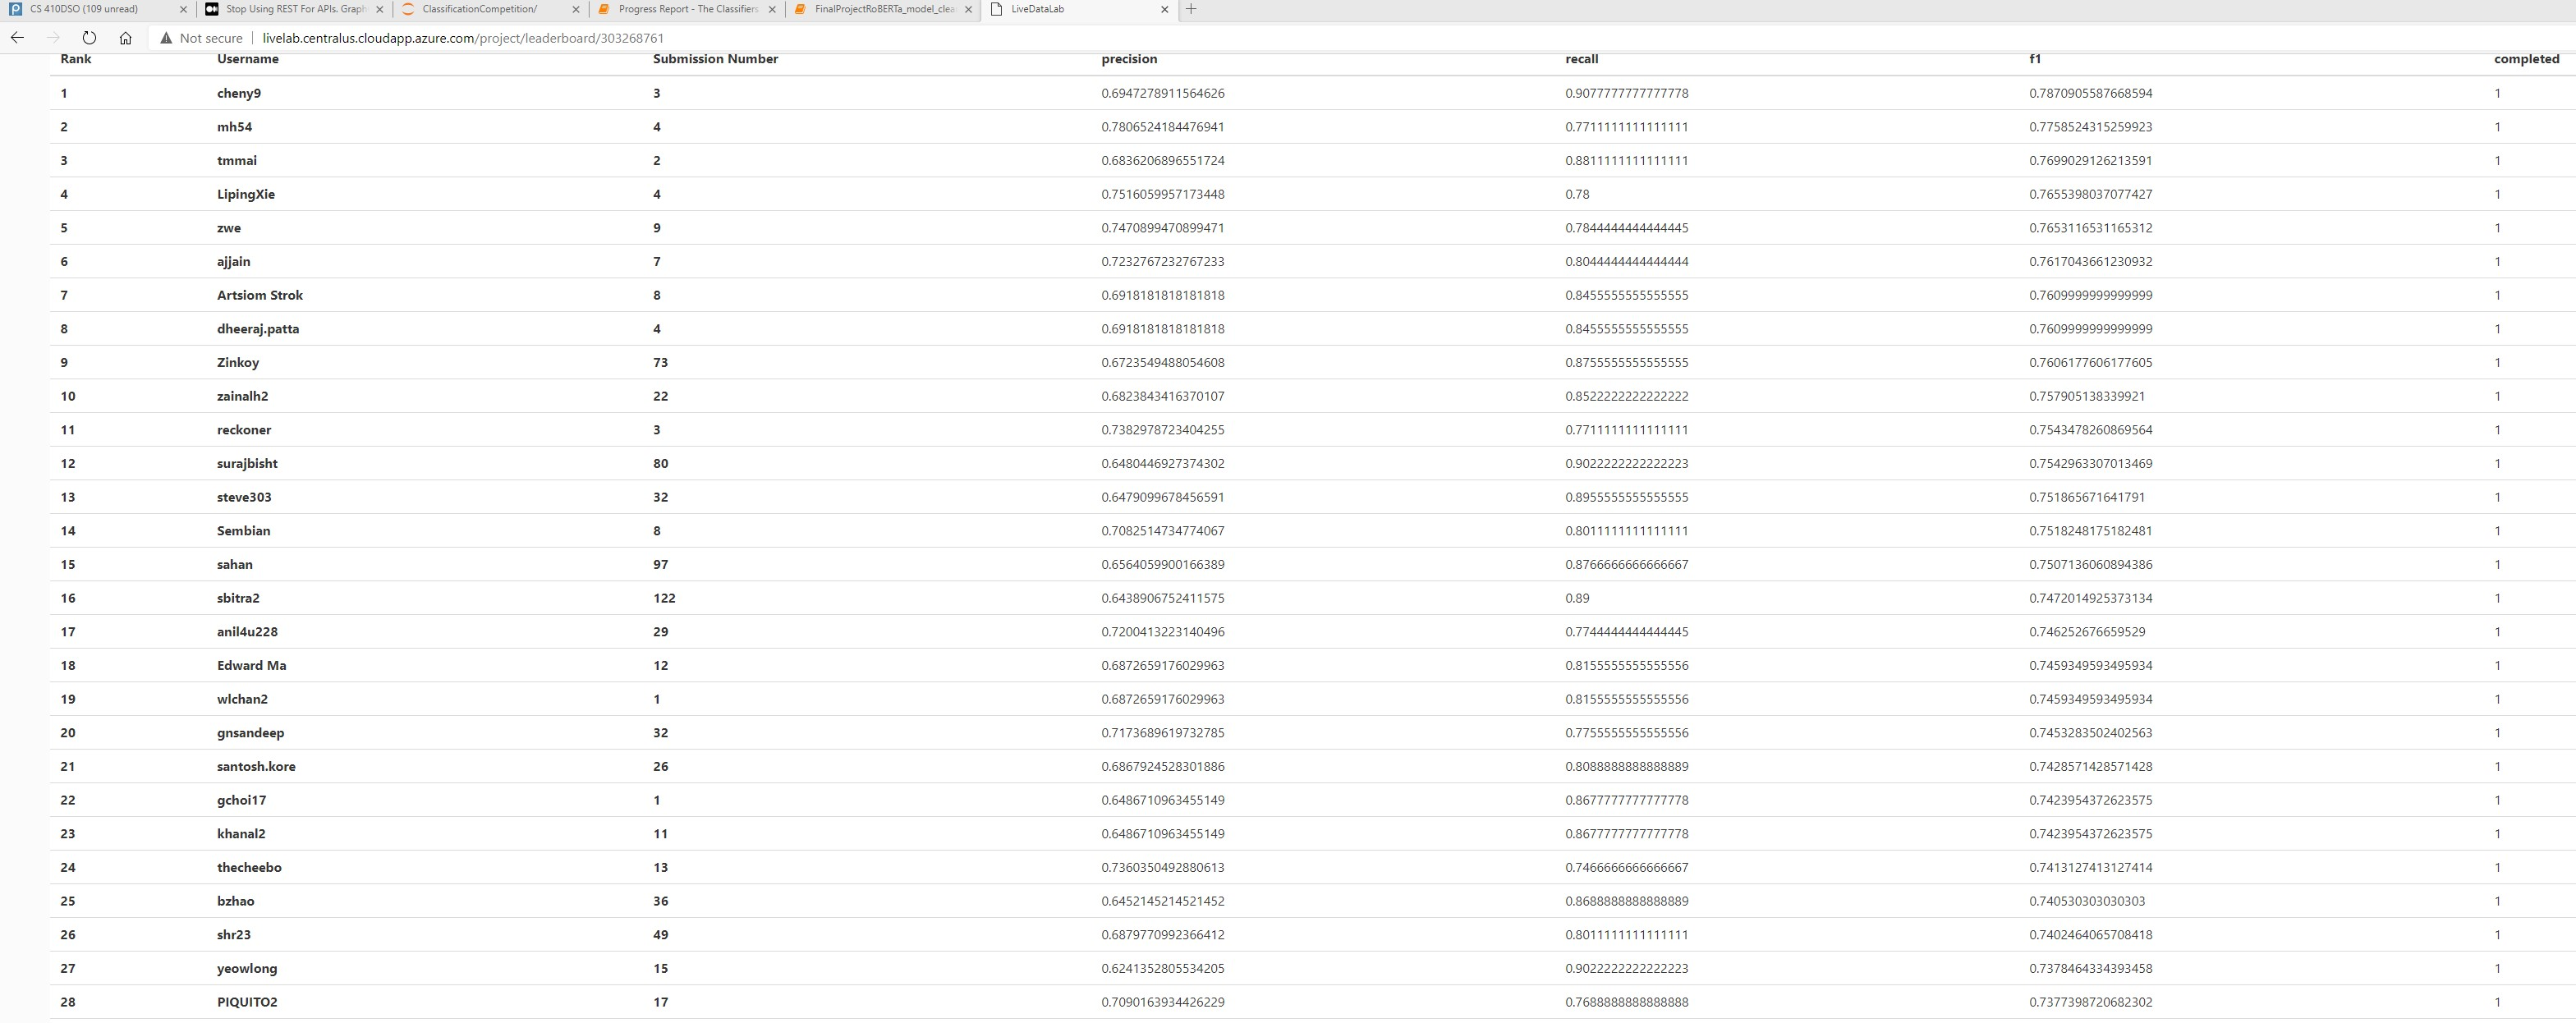